In [4]:
# first version - difficult to uncompute ancillas

sys.path.append("..") # see os.getcwd()
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt


from qiskit import execute, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.circuit.library import NormalDistribution, LogNormalDistribution, LinearAmplitudeFunction, IntegerComparator, WeightedAdder
from qiskit.visualization import plot_histogram
from quantum_mc.arithmetic import multiply_add 

qr_input = QuantumRegister(3, 'input')
qr_result = QuantumRegister(6, 'result')
qr_cond = QuantumRegister(3, 'conditions')
qr_ancilla = QuantumRegister(6, 'ancilla')
output = ClassicalRegister(6, 'output')
circ = QuantumCircuit(qr_input, qr_result, qr_cond, qr_ancilla, output) 

sigma = 1
low = -3
high = 3
mu = 0

normal = NormalDistribution(3, mu=mu, sigma=sigma**2, bounds=(low, high))
circ.append(normal, qr_input)

comp0 = IntegerComparator(num_state_qubits=3, value=3, name = "comparator0") # if true if i >= point
comp1 = IntegerComparator(num_state_qubits=3, value=6, name = "comparator1") # if true if i >= point
trans0 = multiply_add.cond_classical_add_mult(6, 7, qr_input, qr_result, qr_ancilla) 
trans1 = multiply_add.cond_classical_add_mult(1, 17, qr_input, qr_result, qr_ancilla) 
trans2 = multiply_add.cond_classical_add_mult(3, 7, qr_input, qr_result, qr_ancilla)  

circ.append(comp1, qr_input[:] + [qr_cond[2]] + qr_ancilla[0:comp0.num_ancillas])
circ.append(trans2, [qr_cond[2]] + qr_input[:] + qr_result[:] + qr_ancilla[:])

circ.x(qr_cond[2])

circ.append(comp0, qr_input[:] + [qr_cond[0]] + qr_ancilla[0:comp0.num_ancillas])
circ.ccx(qr_cond[0], qr_cond[2], qr_cond[1])
circ.append(trans1, [qr_cond[1]] + qr_input[:] + qr_result[:] + qr_ancilla[:])

circ.x(qr_cond[0])
circ.append(trans0, [qr_cond[0]] + qr_input[:] + qr_result[:] + qr_ancilla[:])

circ.measure(qr_result, output)

#circ.draw()

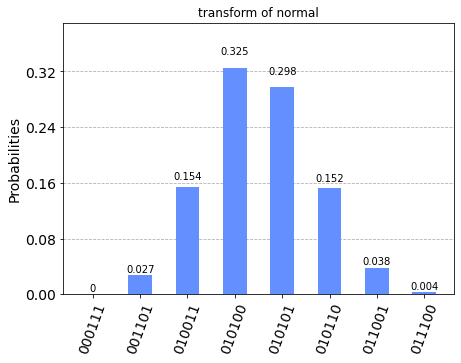

In [5]:
counts = execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts, title = "transform of normal")

In [6]:
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..") # see os.getcwd()
from qiskit import execute, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.circuit.library import NormalDistribution, LogNormalDistribution, LinearAmplitudeFunction, IntegerComparator, WeightedAdder
from qiskit.visualization import plot_histogram
from quantum_mc.arithmetic import multiply_add 

qr_input = QuantumRegister(3, 'input')
qr_result = QuantumRegister(6, 'result')
qr_comp = QuantumRegister(2, 'comparisons')
qr_ancilla = QuantumRegister(6, 'ancilla')
qr_comp_anc = QuantumRegister(3, 'cond_ancilla')
output = ClassicalRegister(6, 'output')
circ = QuantumCircuit(qr_input, qr_result, qr_comp, qr_ancilla, qr_comp_anc, output) 

# our test piece-wise transforms:
# trans0 if x <= 2, x => 6*x + 7
# trans1 if 2 < x <= 5, x => x + 17 
# trans2 if x > 5, x => 3*x + 7

sigma = 1
low = -3
high = 3
mu = 0

normal = NormalDistribution(3, mu=mu, sigma=sigma**2, bounds=(low, high))
circ.append(normal, qr_input)

comp0 = IntegerComparator(num_state_qubits=3, value=3, name = "comparator0") # if true if i >= point
comp1 = IntegerComparator(num_state_qubits=3, value=6, name = "comparator1") # if true if i >= point
trans0 = multiply_add.cond_classical_add_mult(6, 7, qr_input, qr_result, qr_ancilla) 
trans1 = multiply_add.cond_classical_add_mult(1, 17, qr_input, qr_result, qr_ancilla) 
trans2 = multiply_add.cond_classical_add_mult(3, 7, qr_input, qr_result, qr_ancilla)  

circ.append(comp0, qr_input[:] + [qr_comp[0]] + qr_ancilla[0:comp0.num_ancillas])
circ.append(comp1, qr_input[:] + [qr_comp[1]] + qr_ancilla[0:comp0.num_ancillas])

circ.cx(qr_comp[0], qr_comp_anc[0])
circ.x(qr_comp_anc[0])
circ.cx(qr_comp[1], qr_comp_anc[2])
circ.x(qr_comp_anc[2])
circ.ccx(qr_comp[0], qr_comp_anc[2], qr_comp_anc[1])

circ.append(trans0, [qr_comp_anc[0]] + qr_input[:] + qr_result[:] + qr_ancilla[:])
circ.append(trans1, [qr_comp_anc[1]] + qr_input[:] + qr_result[:] + qr_ancilla[:])
circ.append(trans2, [qr_comp[1]] + qr_input[:] + qr_result[:] + qr_ancilla[:])

# can uncompute qr_comp_anc
# then uncompute the comparators 

circ.measure(qr_result, output)

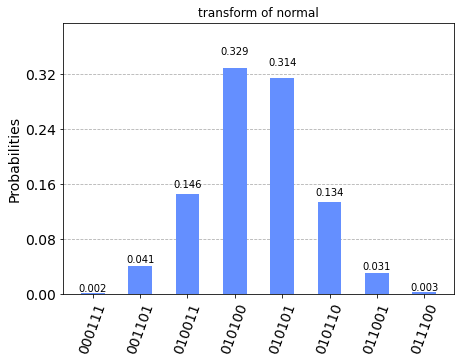

In [7]:
counts = execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts, title = "transform of normal")